# Boston Tourism Ecometric
<hr>

### Group 7

**Meng Forrest,
Michiels Garrett, 
Mitchell Timothy, 
Peter Gabriel,
Pickett Daniel**


## Introduction

For the 2nd mini project, our group created a tourism ecometric using a weighted sum of data from three of the provided data sets: google places, airbnb, and yelp reviews. Tourism is composed of people visiting, staying, and experiencing places that are new to them. Using these three data sets we can measure the tourism in a certain area. The googe places data set allows us to identify points of interest in an area that tourists are likely to visit and be around such as acquariums, museums, and art gallerys. The yelp review dataset allows us to count the number of restaurants listed on yelp in a certain area. The Airbnb dataset allows for a measure of mostly temporary short term housing in an area. By combining these metrics into one ecometric for tourism, we have a much better measure of all of the tourist related activity than could be measured using any single one.

## 1. Read in Data

We first import packages we will be using and read in the provided CSV data for google places, airbnb listings, and yelp restaurants. We use the csv's provided as in from the assignment. They are not modified at all before reading them in. Additionally, we read in a geojson shape file to create a mapping for our ecometric.

In [262]:
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [263]:
# due to some columns with multiple types, low_memory=False avoids python showing an error
places_df = pd.read_csv('data/GooglePlaces.csv', low_memory=False)
airbnb_df = pd.read_csv('data/AIRBNB_Listings.csv', low_memory=False)
yelp_df = pd.read_csv('data/YELP_Restaurants.csv', low_memory=False)
shape_df = gpd.read_file("data/Census_2010_Tracts.geojson")

## 2 / 3. Identifying and Aggregating Columns of Interest

### Columns of interest - Places

The places dataset 'Tag_1' column gives a description of each place. To identify tourism we will filter and only count specific places which we have identified as relating to tourism. This includes art galleries, museums and more. We will avoid banks, doctors, and other non tourist related buildings. When someone visits a new place they are highly unlikely to visit these or if they do it is much less common.

In [264]:
places_df.columns

Index(['GIS_ID', 'place_id', 'name', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4',
       'Tag_5', 'Tag_6', 'Tag_7', 'Tag_8', 'Tag_9', 'Tag_10', 'vicinity', 'X',
       'Y', 'Blk_ID_10', 'CT_ID_10'],
      dtype='object')

To decide which locations available can be used for tourism, we display a list of all the possible locations.

In [265]:
places_df['Tag_1'].unique()

array(['restaurant', 'doctor', 'synagogue', 'general_contractor',
       'clothing_store', 'health', 'bakery', 'bank', 'gym', 'bar',
       'beauty_salon', 'insurance_agency', 'atm', 'physiotherapist',
       'pharmacy', 'grocery_or_supermarket', 'finance', 'shoe_store',
       'local_government_office', 'moving_company', 'car_dealer', 'spa',
       'cafe', 'hair_care', 'store', 'fire_station', 'dentist',
       'accounting', 'lawyer', 'real_estate_agency', 'home_goods_store',
       'laundry', 'convenience_store', 'church', 'movie_theater',
       'place_of_worship', 'parking', 'liquor_store', 'furniture_store',
       'hospital', 'travel_agency', 'embassy', 'bus_station', 'park',
       'courthouse', 'hardware_store', 'art_gallery', 'car_repair',
       'meal_delivery', 'car_rental', 'jewelry_store', 'electrician',
       'storage', 'bicycle_store', 'plumber', 'veterinary_care',
       'lodging', 'electronics_store', 'library', 'museum', 'painter',
       'food', 'night_club', 'roofi

Then we create a list of a subset of these places which relate to tourism.

- park
- acquarium
- museum
- bowling alley
- zoo
- embassy
- night club
- art gallery
- car rental

In [266]:
poi = ['park', 'aquarium', 'museum', 'bowling_alley','stadium', 'zoo', 'embassy', 'night_club', 'art_gallery', 'car_rental']

Finally for googe places, we create a dictionary which maps each census tract id to a count of the number of tourism related places found in that tract. All the census tracts start at 0. For each row, if the rows 'Tag_1' column is within our list of places of interest, we increment the count of that id, otherwise we go to the next row. Then we turn the dictionary into a series to be used to create the ecometric

In [267]:
places_counts = {}

# work from a copy of the dataframe to not modify the source
temp_places_df = places_df.copy()
temp_places_df = temp_places_df.dropna(subset=['CT_ID_10'])
temp_places_df = temp_places_df.reset_index()

# iterate from 0 to number of rows in places data
for r in range(temp_places_df.shape[0]):
    
    # try catch will help with nan and other invalid columns, in this case we pass
    try:
        tract = temp_places_df.at[r, 'CT_ID_10']

        # adjust improperly formatted tracts which end in .0
        if str(tract).endswith('.0'):
            # convert to string remove the last two characters
            tract = str(tract)[:-2]
            # convert back to int
            tract = int(tract)

        tract = int(tract)

        if tract not in places_counts:
            places_counts[tract] = 0

        # row is place of tourism
        if temp_places_df.at[r, 'Tag_1'] in poi:    
            places_counts[tract] += 1
    except:
        pass

places_count = pd.Series(places_counts)
places_count = places_count.rename("counts")
places_count = places_count.rename_axis("CT_ID_10")
places_count

CT_ID_10
25025000802    13
25025040801     5
25025071101     2
25025060600    19
25025040600     2
               ..
25025060200     0
25025980700     0
25025981000     2
25025061101     0
25025981502     0
Name: counts, Length: 181, dtype: int64

### Columns of interest - Airbnb

For airbnb data, we first acknowledged that because we do not have a complete list of all airbnb listings, but only a subset, we must be careful with how we use the data. Therefore we started with simply counting the number of bed spaces in each tract. We are making the assumption that, despite not having every listing, tracts more popular with tourism will still have a net higher count of bed spaces than much less popular areas.

In [268]:
airbnb_df.columns

Index(['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules', 'id',
       'Year', 'Month', 'listing_url', 'picture_url', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'requires_license',
       'license', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'is_business_travel_ready', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_su

We create a series grouped by each tract where the value associated with that tract is the count of airbnbs.

In [269]:
bnb_count = airbnb_df.groupby(by=['CT_ID_10']).sum()['beds']
bnb_count = bnb_count.rename("counts")
bnb_count

CT_ID_10
25017342400     14.0
25017350103      2.0
25017350104      1.0
25017350400      7.0
25017350500     16.0
               ...  
25025981202     83.0
25025981300     71.0
25025981501    323.0
25025981700     30.0
25025981800    931.0
Name: counts, Length: 249, dtype: float64

### Columns of interest - Yelp

For yelp we count the number of restuarants in each tract. We use this to get a general idea of how many options would be availble to a person visting a certain location. An area with a lot of resaurants could be more popular for tourism. We haven't distinguished based on price because both inexpensive and expensive restaurants could be popular depending on the type of tourist.

In [270]:
yelp_df.columns

Index(['restaurant_name', 'restaurant_ID', 'restaurant_address',
       'restaurant_tag', 'rating', 'price', 'review_number', 'unique_reviewer',
       'reviews_Jan_19', 'reviews_Feb_19', 'reviews_Mar_19', 'reviews_Apr_19',
       'reviews_May_19', 'reviews_Jun_19', 'reviews_Jul_19', 'reviews_Aug_19',
       'reviews_Jan_20', 'reviews_Feb_20', 'reviews_Mar_20', 'reviews_Apr_20',
       'reviews_May_20', 'reviews_Jun_20', 'reviews_Jul_20', 'reviews_Aug_20',
       'restaurant_neighborhood', 'GIS_ID', 'CT_ID_10'],
      dtype='object')

We create a series grouped by each tract where the value associated with that tract is the count of restaurants.

In [271]:
res_count = yelp_df.groupby(by=['CT_ID_10']).count()['restaurant_name']
res_count = res_count.rename("counts")
res_count

CT_ID_10
25025000100    21
25025000201    12
25025000202     8
25025000301     7
25025000302     5
               ..
25025981300    60
25025981501     1
25025981600     1
25025981700     1
25025990101     1
Name: counts, Length: 169, dtype: int64

## 3. Joining for Ecometric

With three series representing housing, restaurants, and tourist locations, we can now join these into creating our tourism ecometric.

All of the series are converted into a dataframe and then joined on the 'CT_ID_10' column using an inner join. This means to construct our final ecometric we will only includes tracts that have data from all three of our series. Although we may miss out on a few tracts, all of the tracts that we do create an ecometric for we know are backed by our data.

In [272]:
cols = {'airbnb':bnb_count}
bnb_df = pd.DataFrame(cols)

cols1 = {'places':places_count}
places_df = pd.DataFrame(cols1)

cols2 = {'rest':res_count}
rest_df = pd.DataFrame(cols2)

In [273]:
bnb_places = bnb_df.join(places_df, how='inner', sort=False)
combined_df = bnb_places.join(rest_df, how='inner', sort=False)
combined_df.head()

,airbnb,places,rest
CT_ID_10,,,
25025000100,1464.0,8,21
25025000201,452.0,0,12
25025000202,155.0,0,8
25025000301,413.0,0,7
25025000302,632.0,0,5


Since each of the three seperate measurements have different units and scales, we normalize the data before creating our ecometric. This is because we don't want 323 bed spaces in a tract to count 323x more towards the ecometric than 1 restaurant. By scaling each of the columns the same they can be merged together to create our final metric. MinMaxScaler specifically ensures that all the values within a specific column are between 0-1. Therefore, when we sum the three values for our ecometric we will get a final tourism metric for each tract between 0 and 3.

In [274]:
scaler = MinMaxScaler()

scaled_df = combined_df.copy()

# Apply to each column
scaled_df['airbnb'] = scaler.fit_transform(scaled_df['airbnb'].values.reshape(-1,1))
scaled_df['places'] = scaler.fit_transform(scaled_df['places'].values.reshape(-1,1))
scaled_df['rest'] = scaler.fit_transform(scaled_df['rest'].values.reshape(-1,1))

scaled_df.head()

,airbnb,places,rest
CT_ID_10,,,
25025000100,0.235123,0.133333,0.077519
25025000201,0.071924,0.000000,0.042636
25025000202,0.024028,0.000000,0.027132
25025000301,0.065635,0.000000,0.023256
25025000302,0.100951,0.000000,0.015504


Combined the three values, weighted equally, to create final ecometric.

In [275]:
scaled_df['ecometric'] = \
1 * scaled_df['airbnb'] +  1 * scaled_df['places'] + 1 * scaled_df['rest']

# select only the ecometric column
ecometric_df = scaled_df.filter(['ecometric'], axis=1)
ecometric_df.head()

,ecometric
CT_ID_10,
25025000100,0.445976
25025000201,0.114560
25025000202,0.051160
25025000301,0.088890
25025000302,0.116455


## 4. Analysis / Visualizations

### Mapping

To create a choropleth map using geopandas the ecometric column is joined with a boston geojson file on the shared census tract id column. Then the plot is created using our ecometric for the scale.

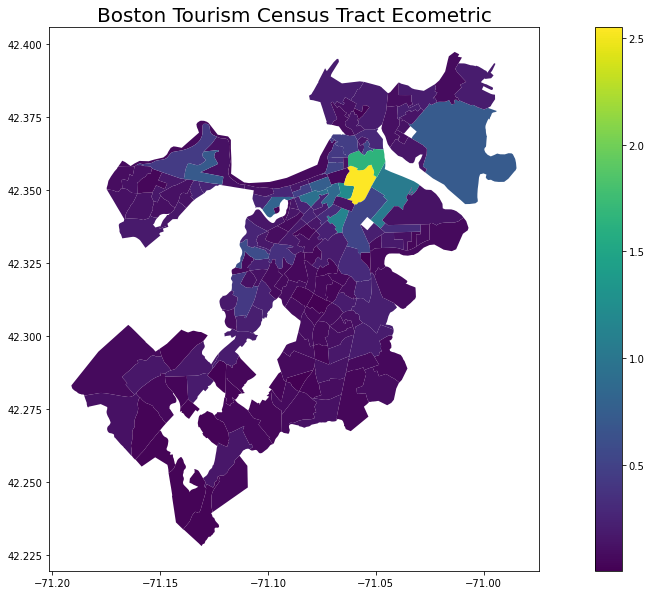

In [276]:
# rename the shape file to have matching column name for census tract as our ecometric
shape_df = shape_df.rename(columns={'GEOID10':'CT_ID_10'})
# ensure both are type int64
shape_df = shape_df.astype({'CT_ID_10': 'int64'})

# join ecometric and shape df
map_df = pd.merge(shape_df, ecometric_df, on='CT_ID_10')

map_df.plot(column = 'ecometric', legend=True, figsize=(20,10))
plt.title('Boston Tourism Census Tract Ecometric', fontsize = 20)
plt.show()

Todo : Explain map

### Statistics and Plots

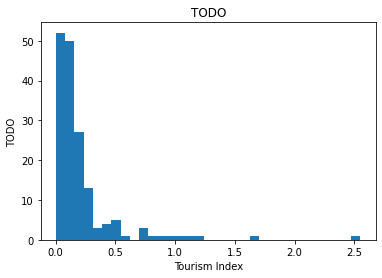

In [277]:
bins = int(ecometric_df.shape[0]/5)
ecometric_df_unindexed = ecometric_df.reset_index()
plt.hist(ecometric_df_unindexed['ecometric'], bins=bins)
plt.xlabel("Tourism Index")
plt.ylabel("TODO")
plt.title("TODO")
plt.show()

By binning the census tracts together we can see that tourism is very concentrated in Boston. There are a few tracts which have much more tourism than all the others. The vast majority of tracts in Boston have little tourism (by our ecometric) in comparison. This result aligns with our map above which shows downtown having a much higher ecometric as there are much more resturants, places of interest, and airbnbs.

In [278]:
for col in combined_df.columns:
    print(col, '\n', combined_df[col].describe())
    print('-' * 30, '\n')
combined_df.corr()

airbnb 
 count     166.000000
mean      632.475904
std       730.927171
min         6.000000
25%       200.750000
50%       444.500000
75%       767.000000
max      6207.000000
Name: airbnb, dtype: float64
------------------------------ 

places 
 count    166.000000
mean       3.114458
std        7.477167
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       60.000000
Name: places, dtype: float64
------------------------------ 

rest 
 count    166.000000
mean      16.030120
std       29.203243
min        1.000000
25%        4.000000
50%        9.000000
75%       16.750000
max      259.000000
Name: rest, dtype: float64
------------------------------ 



,airbnb,places,rest
airbnb,1.000000,0.442344,0.666097
places,0.442344,1.000000,0.655762
rest,0.666097,0.655762,1.000000


todo: Explain metrics

In [279]:
ecometric_df.describe()

,ecometric
count,166.000000
mean,0.211192
std,0.302499
min,0.003876
25%,0.070705
50%,0.119119
75%,0.212709
max,2.550000


todo: Explain ecometric metrics

### Questions

todo: paste in some q answers from google doc

We have answered many throughout our notebook and also compiled questions here. 

**What is the phenomenon that you are trying to measure through your newly generated variable? In other words – define your concept.**


**How do the variables you included in your measure relate to your concept of interest?**

**How did you address missing data? How much of it was there? Why did you choose this strategy?**

**What strategy did you choose to aggregate your data from record-level to neighborhood-level information? Why was this the most appropriate strategy for measuring your concept of interest?**

**What do the statistics and visualization you produced tell us about the state of disorder/gentrification/tourism/etc. across Boston neighborhoods?**

**What types of additional information or variables might have enhanced your ability to represent your chosen phenomenon through data?**